(odu_v2)=
```{raw} html
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# Job Search VII: Search with Learning

```{contents} Contents
:depth: 2
```

In addition to what’s in Anaconda, this lecture deploys the libraries:

In [1]:
  !pip install quantecon
  !pip install interpolation

## Overview

In this lecture, we consider an extension of the [previously studied](https://python.quantecon.org/mccall_model.html) job search model of McCall
{cite}`McCall1970`.

We'll build on a model of Bayesian learning discussed in [this lecture](https://python.quantecon.org/exchangeable.html) on the topic of exchangeability and its relationship to
the concept of IID (identically and independently distributed) random variables and to  Bayesian updating.

In the McCall model, an unemployed worker decides when to accept a
permanent job at a specific fixed wage, given

- his or her discount factor
- the level of unemployment compensation
- the distribution from which wage offers are drawn

In the version considered below, the wage distribution is unknown and
must be learned.

- The following is based on the presentation in
  {cite}`Ljungqvist2012`, section 6.6.

Let’s start with some imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
from numba import njit, prange, vectorize
from interpolation import mlinterp, interp
from math import gamma
import numpy as np
from matplotlib import cm
import scipy.optimize as op
from scipy.stats import cumfreq, beta

### Model Features

- Infinite horizon dynamic programming with two states and one binary
  control.
- Bayesian updating to learn the unknown distribution.

## Model

Let’s first review the basic McCall model
{cite}`McCall1970` and then add the variation we
want to consider.

### The Basic McCall Model

Recall that, {doc}`in the baseline model <mccall_model>`, an
unemployed worker is presented in each period with a permanent job offer
at wage $W_t$.

At time $t$, our worker either

1. accepts the offer and works permanently at constant wage $W_t$
1. rejects the offer, receives unemployment compensation $c$ and
   reconsiders next period

The wage sequence ${W_t}$ is IID and generated from known density $q$.

The worker aims to maximize the expected discounted sum of earnings
$\mathbb{E} \sum_{t=0}^{\infty}\beta^t y_t$.

Let $v(w)$ be the optimal value of the problem for a previously unemployed worker who has just received offer $w$ and is
yet to decide whether to accept or reject the offer.

The value  function $v$ satisfies the recursion

```{math}
:label: odu_odu_pv

v(w)
= \max \left\{
\frac{w}{1 - \beta}, \, c + \beta \int v(w')q(w') dw'
\right\}
```

The optimal policy has the form $\mathbf{1}\{w \geq \bar w\}$, where
$\bar w$ is a constant called the *reservation wage*.

### Offer Distribution Unknown

Now let’s extend the model by considering the variation presented in
{cite}`Ljungqvist2012`, section 6.6.

The model is as above, apart from the fact that

- the density $q$ is unknown
- the worker learns about $q$ by starting with a prior and updating
  based on wage offers that he/she observes

The worker knows there are two possible distributions $F$ and $G$.

These two distributions have  densities $f$ and $g$, repectively.

Just before time starts,  “nature” selects $q$ to be either $f$ or $g$.

This is then the wage distribution from which the entire sequence ${W_t}$ will be
drawn.

The worker does not know which distribution nature has drawn, but the worker does know
the two possible distributions $f$ and $g$.

The worker  puts a (subjective) prior probability $\pi_0$ on $f$ having been  chosen.

The worker's time $0$ subjective distribution for the distribution of $W_0$ is

$$
\pi_0 f + (1 - \pi_0) g
$$



The  worker's time $t$ subjective belief about the  the distribution of $W_t$  is

$$
\pi_t f + (1 - \pi_t) g,
$$

where $\pi_t$ updates via

```{math}
:label: odu_pi_rec_2

\pi_{t+1}
= \frac{\pi_t f(w_{t+1})}{\pi_t f(w_{t+1}) + (1 - \pi_t) g(w_{t+1})}
```

This last expression follows from Bayes’ rule, which tells us that

$$
\mathbb{P}\{q = f \,|\, W = w\}
= \frac{\mathbb{P}\{W = w \,|\, q = f\}\mathbb{P}\{q = f\}}
{\mathbb{P}\{W = w\}}
\quad \text{and} \quad
\mathbb{P}\{W = w\} = \sum_{\omega \in \{f, g\}} \mathbb{P}\{W = w \,|\, q = \omega\} \mathbb{P}\{q = \omega\}
$$

The fact that {eq}`odu_pi_rec_2` is recursive allows us to
progress to a recursive solution method.

Letting

$$
q_{\pi}(w) := \pi f(w) + (1 - \pi) g(w)
\quad \text{and} \quad
\kappa(w, \pi) := \frac{\pi f(w)}{\pi f(w) + (1 - \pi) g(w)}
$$

we can express the value function for the unemployed worker recursively
as follows

```{math}
:label: odu_mvf

v(w, \pi)
= \max \left\{
\frac{w}{1 - \beta}, \, c + \beta \int v(w', \pi') \, q_{\pi}(w') \, dw'
\right\}
\quad \text{where} \quad
\pi' = \kappa(w', \pi)
```

Notice that the current guess $\pi$ is a state variable,
since it affects the worker’s perception of probabilities for future
rewards.

### Parameterization

Following section 6.6 of {cite}`Ljungqvist2012`,
our baseline parameterization will be

- $f$ is $\operatorname{Beta}(1, 1)$
- $g$ is $\operatorname{Beta}(3, 1.2)$
- $\beta = 0.95$ and $c = 0.3$

The densities $f$ and $g$ have the following shape

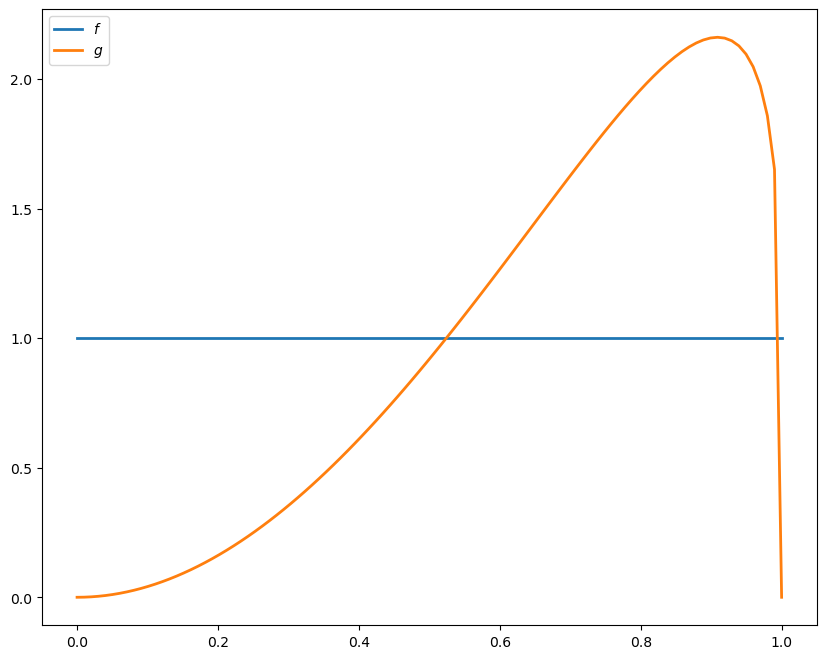

In [3]:
@vectorize
def p(x, a, b):
    r = gamma(a + b) / (gamma(a) * gamma(b))
    return r * x**(a-1) * (1 - x)**(b-1)


x_grid = np.linspace(0, 1, 100)
f = lambda x: p(x, 1, 1)
g = lambda x: p(x, 3, 1.2)

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(x_grid, f(x_grid), label='$f$', lw=2)
ax.plot(x_grid, g(x_grid), label='$g$', lw=2)

ax.legend()
plt.show()

(looking-forward)=
### Looking Forward

What kind of optimal policy might result from
{eq}`odu_mvf` and the parameterization specified above?

Intuitively, if we accept at $w_a$ and $w_a\leq w_b$,
then — all other things being given — we should also accept at $w_b$.

This suggests a policy of accepting whenever $w$ exceeds some
threshold value $\bar w$.

But $\bar w$ should depend on $\pi$ — in
fact, it should be decreasing in $\pi$ because

- $f$ is a less attractive offer distribution than $g$
- larger $\pi$ means more weight on $f$ and less on
  $g$

Thus,  larger $\pi$ depresses the worker’s assessment of
her future prospects, so relatively low current offers become more
attractive.

**Summary:** We conjecture that the optimal policy is of the form
$\mathbb 1{w\geq \bar w(\pi) }$ for some
decreasing function $\bar w$.

(take-1-solution-by-vfi)=
## Take 1: Solution by VFI

Let’s set about solving the model and see how our results match with our
intuition.

We begin by solving via value function iteration (VFI), which is natural
but ultimately turns out to be second best.

The class `SearchProblem` is used to store parameters and methods
needed to compute optimal actions.

In [4]:
class SearchProblem:
    """
    A class to store a given parameterization of the "offer distribution
    unknown" model.

    """

    def __init__(self,
                 β=0.95,            # Discount factor
                 c=0.3,             # Unemployment compensation
                 F_a=1,
                 F_b=1,
                 G_a=3,
                 G_b=1.2,
                 w_max=1,           # Maximum wage possible
                 w_grid_size=100,
                 π_grid_size=100,
                 mc_size=500):

        self.β, self.c, self.w_max = β, c, w_max

        self.f = njit(lambda x: p(x, F_a, F_b))
        self.g = njit(lambda x: p(x, G_a, G_b))

        self.π_min, self.π_max = 1e-3, 1-1e-3    # Avoids instability
        self.w_grid = np.linspace(0, w_max, w_grid_size)
        self.π_grid = np.linspace(self.π_min, self.π_max, π_grid_size)

        self.mc_size = mc_size

        self.w_f = np.random.beta(F_a, F_b, mc_size)
        self.w_g = np.random.beta(G_a, G_b, mc_size)

The following function takes an instance of this class and returns
jitted versions of the Bellman operator `T`, and a `get_greedy()`
function to compute the approximate optimal policy from a guess `v` of
the value function

In [5]:
def operator_factory(sp, parallel_flag=True):

    f, g = sp.f, sp.g
    w_f, w_g = sp.w_f, sp.w_g
    β, c = sp.β, sp.c
    mc_size = sp.mc_size
    w_grid, π_grid = sp.w_grid, sp.π_grid

    @njit
    def v_func(x, y, v):
        return mlinterp((w_grid, π_grid), v, (x, y))

    @njit
    def κ(w, π):
        """
        Updates π using Bayes' rule and the current wage observation w.
        """
        pf, pg = π * f(w), (1 - π) * g(w)
        π_new = pf / (pf + pg)

        return π_new

    @njit(parallel=parallel_flag)
    def T(v):
        """
        The Bellman operator.

        """
        v_new = np.empty_like(v)

        for i in prange(len(w_grid)):
            for j in prange(len(π_grid)):
                w = w_grid[i]
                π = π_grid[j]

                v_1 = w / (1 - β)

                integral_f, integral_g = 0, 0
                for m in prange(mc_size):
                    integral_f += v_func(w_f[m], κ(w_f[m], π), v)
                    integral_g += v_func(w_g[m], κ(w_g[m], π), v)
                integral = (π * integral_f + (1 - π) * integral_g) / mc_size

                v_2 = c + β * integral
                v_new[i, j] = max(v_1, v_2)

        return v_new

    @njit(parallel=parallel_flag)
    def get_greedy(v):
        """"
        Compute optimal actions taking v as the value function.

        """
        σ = np.empty_like(v)

        for i in prange(len(w_grid)):
            for j in prange(len(π_grid)):
                w = w_grid[i]
                π = π_grid[j]

                v_1 = w / (1 - β)

                integral_f, integral_g = 0, 0
                for m in prange(mc_size):
                    integral_f += v_func(w_f[m], κ(w_f[m], π), v)
                    integral_g += v_func(w_g[m], κ(w_g[m], π), v)
                integral = (π * integral_f + (1 - π) * integral_g) / mc_size

                v_2 = c + β * integral

                σ[i, j] = v_1 > v_2  # Evaluates to 1 or 0

        return σ

    return T, get_greedy

We will omit a detailed discussion of the code because there is a more
efficient solution method that we will use later.

To solve the model we will use the following function that iterates
using T to find a fixed point

In [6]:
def solve_model(sp,
                use_parallel=True,
                tol=1e-4,
                max_iter=1000,
                verbose=True,
                print_skip=5):

    """
    Solves for the value function

    * sp is an instance of SearchProblem
    """

    T, _ = operator_factory(sp, use_parallel)

    # Set up loop
    i = 0
    error = tol + 1
    m, n = len(sp.w_grid), len(sp.π_grid)

    # Initialize v
    v = np.zeros((m, n)) + sp.c / (1 - sp.β)

    while i < max_iter and error > tol:
        v_new = T(v)
        error = np.max(np.abs(v - v_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        v = v_new

    if error > tol:
        print("Failed to converge!")
    elif verbose:
        print(f"\nConverged in {i} iterations.")


    return v_new

Let’s look at solutions computed from value function iteration

Error at iteration 5 is 0.5763634739657402.


Error at iteration 10 is 0.08567166831651285.


Error at iteration 15 is 0.017620786134939337.


Error at iteration 20 is 0.0037225556764344248.


Error at iteration 25 is 0.0007878564538899013.


Error at iteration 30 is 0.0001666366606247749.



Converged in 32 iterations.


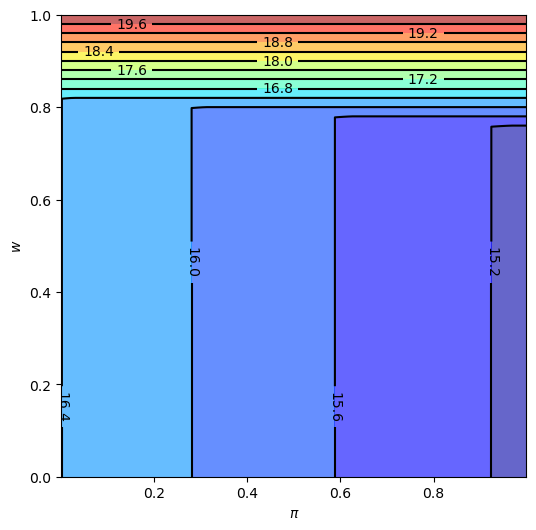

In [7]:
sp = SearchProblem()
v_star = solve_model(sp)
fig, ax = plt.subplots(figsize=(6, 6))
ax.contourf(sp.π_grid, sp.w_grid, v_star, 12, alpha=0.6, cmap=cm.jet)
cs = ax.contour(sp.π_grid, sp.w_grid, v_star, 12, colors="black")
ax.clabel(cs, inline=1, fontsize=10)
ax.set(xlabel='$\pi$', ylabel='$w$')

plt.show()

We will also plot the optimal policy

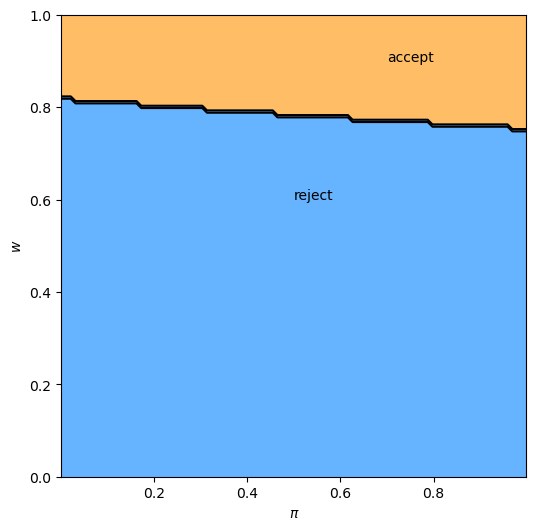

In [8]:
T, get_greedy = operator_factory(sp)
σ_star = get_greedy(v_star)

fig, ax = plt.subplots(figsize=(6, 6))
ax.contourf(sp.π_grid, sp.w_grid, σ_star, 1, alpha=0.6, cmap=cm.jet)
ax.contour(sp.π_grid, sp.w_grid, σ_star, 1, colors="black")
ax.set(xlabel='$\pi$', ylabel='$w$')

ax.text(0.5, 0.6, 'reject')
ax.text(0.7, 0.9, 'accept')

plt.show()

The results fit well with our intuition from section [looking
forward](looking-forward).

- The black line in the figure above corresponds to the function
  $\bar w(\pi)$ introduced there.
- It is decreasing as expected.

## Take 2: A More Efficient Method

Let’s consider another method to solve for the optimal policy.

We will use iteration with an operator that has the same contraction
rate as the Bellman operator, but

- one dimensional rather than two dimensional
- no maximization step

As a consequence, the algorithm is orders of magnitude faster than VFI.

This section illustrates the point that when it comes to programming, a
bit of mathematical analysis goes a long way.

## Another Functional Equation

To begin, note that when $w = \bar w(\pi)$, the worker is indifferent
between accepting and rejecting.

Hence the two choices on the right-hand side of {eq}`odu_mvf` have equal value:

```{math}
:label: odu_mvf2

\frac{\bar w(\pi)}{1 - \beta}
= c + \beta \int v(w', \pi') \, q_{\pi}(w') \, dw'
```

Together, {eq}`odu_mvf` and {eq}`odu_mvf2` give

```{math}
:label: odu_mvf3

v(w, \pi) =
\max
\left\{
    \frac{w}{1 - \beta} ,\, \frac{\bar w(\pi)}{1 - \beta}
\right\}
```

Combining {eq}`odu_mvf2` and {eq}`odu_mvf3`, we obtain

$$
\frac{\bar w(\pi)}{1 - \beta}
= c + \beta \int \max \left\{
    \frac{w'}{1 - \beta} ,\, \frac{\bar w(\pi')}{1 - \beta}
\right\}
\, q_{\pi}(w') \, dw'
$$

Multiplying by $1 - \beta$, substituting in $\pi' = \kappa(w', \pi)$
and using $\circ$ for composition of functions yields

```{math}
:label: odu_mvf4

\bar w(\pi)
= (1 - \beta) c +
\beta \int \max \left\{ w', \bar w \circ \kappa(w', \pi) \right\} \, q_{\pi}(w') \, dw'
```

Equation {eq}`odu_mvf4` can be understood as a functional equation, where $\bar w$ is the unknown function.

* Let's call it the *reservation wage functional equation* (RWFE).
* The solution $\bar w$ to the RWFE is the object that we wish to compute.

## Solving the RWFE

To solve the RWFE, we will first show that its solution is the
fixed point of a [contraction mapping](https://en.wikipedia.org/wiki/Contraction_mapping).

To this end, let

* $b[0,1]$ be the bounded real-valued functions on $[0,1]$
* $\| \omega \| := \sup_{x \in [0,1]} | \omega(x) |$

Consider the operator $Q$ mapping $\omega \in b[0,1]$ into $Q\omega \in b[0,1]$ via

```{math}
:label: odu_dq

(Q \omega)(\pi)
= (1 - \beta) c +
\beta \int \max \left\{ w', \omega \circ \kappa(w', \pi) \right\} \, q_{\pi}(w') \, dw'
```

Comparing {eq}`odu_mvf4` and {eq}`odu_dq`, we see that the set of fixed points of $Q$ exactly coincides with the set of solutions to the RWFE.

* If $Q \bar w = \bar w$ then $\bar w$ solves {eq}`odu_mvf4` and vice versa.

Moreover, for any $\omega, \omega' \in b[0,1]$, basic algebra and the
triangle inequality for integrals tells us that

```{math}
:label: odu_nt

|(Q \omega)(\pi) - (Q \omega')(\pi)|
\leq \beta \int
\left|
\max \left\{w', \omega \circ \kappa(w', \pi) \right\} -
\max \left\{w', \omega' \circ \kappa(w', \pi) \right\}
\right|
\, q_{\pi}(w') \, dw'
```

Working case by case, it is easy to check that for real numbers $a, b, c$ we always have

```{math}
:label: odu_nt2

| \max\{a, b\} - \max\{a, c\}| \leq | b - c|
```

Combining {eq}`odu_nt` and {eq}`odu_nt2` yields

```{math}
:label: odu_nt3

|(Q \omega)(\pi) - (Q \omega')(\pi)|
\leq \beta \int
\left| \omega \circ \kappa(w', \pi) -  \omega' \circ \kappa(w', \pi) \right|
\, q_{\pi}(w') \, dw'
\leq \beta \| \omega - \omega' \|
```

Taking the supremum over $\pi$ now gives us

```{math}
:label: odu_rwc

\|Q \omega - Q \omega'\|
\leq \beta \| \omega - \omega' \|
```

In other words, $Q$ is a contraction of modulus $\beta$ on the
complete metric space $(b[0,1], \| \cdot \|)$.

Hence

* A unique solution $\bar w$ to the RWFE exists in $b[0,1]$.
* $Q^k \omega \to \bar w$ uniformly as $k \to \infty$, for any $\omega \in b[0,1]$.

## Implementation

The following function takes an instance of `SearchProblem` and
returns the operator `Q`

In [9]:
def Q_factory(sp, parallel_flag=True):

    f, g = sp.f, sp.g
    w_f, w_g = sp.w_f, sp.w_g
    β, c = sp.β, sp.c
    mc_size = sp.mc_size
    w_grid, π_grid = sp.w_grid, sp.π_grid

    @njit
    def ω_func(p, ω):
        return interp(π_grid, ω, p)

    @njit
    def κ(w, π):
        """
        Updates π using Bayes' rule and the current wage observation w.
        """
        pf, pg = π * f(w), (1 - π) * g(w)
        π_new = pf / (pf + pg)

        return π_new

    @njit(parallel=parallel_flag)
    def Q(ω):
        """

        Updates the reservation wage function guess ω via the operator
        Q.

        """
        ω_new = np.empty_like(ω)

        for i in prange(len(π_grid)):
            π = π_grid[i]
            integral_f, integral_g = 0, 0

            for m in prange(mc_size):
                integral_f += max(w_f[m], ω_func(κ(w_f[m], π), ω))
                integral_g += max(w_g[m], ω_func(κ(w_g[m], π), ω))
            integral = (π * integral_f + (1 - π) * integral_g) / mc_size

            ω_new[i] = (1 - β) * c + β * integral

        return ω_new

    return Q

In the next exercise, you are asked to compute an approximation to
$\bar w$.

## Exercises

```{exercise}
:label: odu_ex1

Use the default parameters and `Q_factory` to compute an optimal
policy.

Your result should coincide closely with the figure for the optimal
policy [shown above](take-1-solution-by-vfi).

Try experimenting with different parameters, and confirm that the change
in the optimal policy coincides with your intuition.
```

## Solutions

```{solution-start} odu_ex1
:class: dropdown
```

This code solves the “Offer Distribution Unknown” model by iterating on
a guess of the reservation wage function.

You should find that the run time is shorter than that of the value
function approach.

Similar to above, we set up a function to iterate with `Q` to find the
fixed point

In [10]:
def solve_wbar(sp,
               use_parallel=True,
               tol=1e-4,
               max_iter=1000,
               verbose=True,
               print_skip=5):

    Q = Q_factory(sp, use_parallel)

    # Set up loop
    i = 0
    error = tol + 1
    m, n = len(sp.w_grid), len(sp.π_grid)

    # Initialize w
    w = np.ones_like(sp.π_grid)

    while i < max_iter and error > tol:
        w_new = Q(w)
        error = np.max(np.abs(w - w_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        w = w_new

    if error > tol:
        print("Failed to converge!")
    elif verbose:
        print(f"\nConverged in {i} iterations.")

    return w_new

The solution can be plotted as follows

Error at iteration 5 is 0.02152242133644433.
Error at iteration 10 is 0.006500336260032991.
Error at iteration 15 is 0.0014770292398224028.
Error at iteration 20 is 0.0003040223209150872.

Converged in 24 iterations.


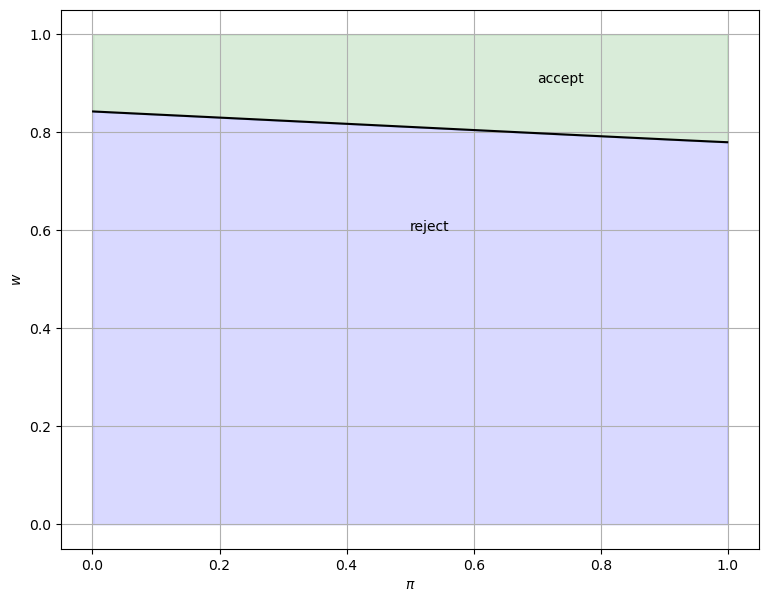

In [11]:
sp = SearchProblem()
w_bar = solve_wbar(sp)

fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(sp.π_grid, w_bar, color='k')
ax.fill_between(sp.π_grid, 0, w_bar, color='blue', alpha=0.15)
ax.fill_between(sp.π_grid, w_bar, sp.w_max, color='green', alpha=0.15)
ax.text(0.5, 0.6, 'reject')
ax.text(0.7, 0.9, 'accept')
ax.set(xlabel='$\pi$', ylabel='$w$')
ax.grid()
plt.show()

```{solution-end}
```

## Appendix A

The next piece of code generates a fun simulation to see what the effect
of a change in the underlying distribution on the unemployment rate is.

At a point in the simulation, the distribution becomes significantly
worse.

It takes a while for agents to learn this, and in the meantime, they are
too optimistic and turn down too many jobs.

As a result, the unemployment rate spikes

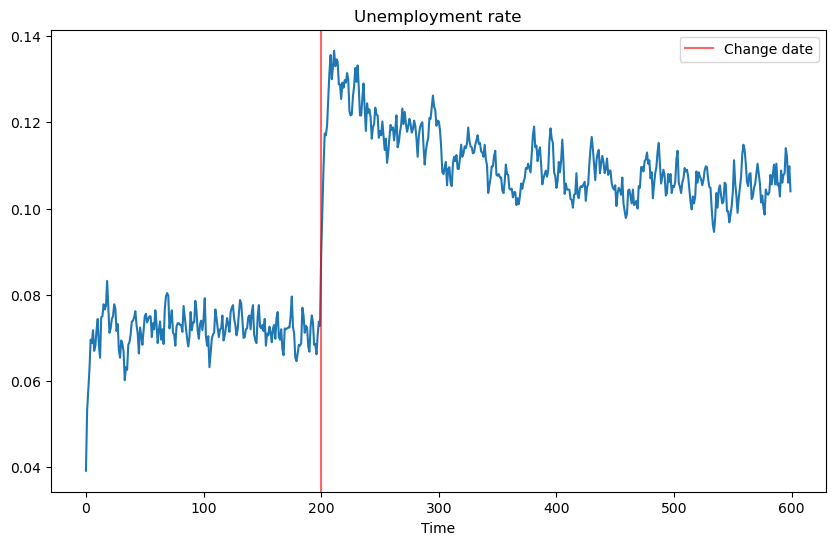

In [12]:
F_a, F_b, G_a, G_b = 1, 1, 3, 1.2

sp = SearchProblem(F_a=F_a, F_b=F_b, G_a=G_a, G_b=G_b)
f, g = sp.f, sp.g

# Solve for reservation wage
w_bar = solve_wbar(sp, verbose=False)

# Interpolate reservation wage function
π_grid = sp.π_grid
w_func = njit(lambda x: interp(π_grid, w_bar, x))

@njit
def update(a, b, e, π):
    "Update e and π by drawing wage offer from beta distribution with parameters a and b"

    if e == False:
        w = np.random.beta(a, b)       # Draw random wage
        if w >= w_func(π):
            e = True                   # Take new job
        else:
            π = 1 / (1 + ((1 - π) * g(w)) / (π * f(w)))

    return e, π

@njit
def simulate_path(F_a=F_a,
                  F_b=F_b,
                  G_a=G_a,
                  G_b=G_b,
                  N=5000,       # Number of agents
                  T=600,        # Simulation length
                  d=200,        # Change date
                  s=0.025):     # Separation rate

    """Simulates path of employment for N number of works over T periods"""

    e = np.ones((N, T+1))
    π = np.full((N, T+1), 1e-3)

    a, b = G_a, G_b   # Initial distribution parameters

    for t in range(T+1):

        if t == d:
            a, b = F_a, F_b  # Change distribution parameters

        # Update each agent
        for n in range(N):
            if e[n, t] == 1:                    # If agent is currently employment
                p = np.random.uniform(0, 1)
                if p <= s:                      # Randomly separate with probability s
                    e[n, t] = 0

            new_e, new_π = update(a, b, e[n, t], π[n, t])
            e[n, t+1] = new_e
            π[n, t+1] = new_π

    return e[:, 1:]

d = 200  # Change distribution at time d
unemployment_rate = 1 - simulate_path(d=d).mean(axis=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(unemployment_rate)
ax.axvline(d, color='r', alpha=0.6, label='Change date')
ax.set_xlabel('Time')
ax.set_title('Unemployment rate')
ax.legend()
plt.show()

## Appendix B

In this appendix we provide more details about how Bayes' Law contributes to the workings of the model.

We present some graphs that bring out additional insights about how learning works.

We build on graphs proposed in [this lecture](https://python.quantecon.org/exchangeable.html).

In particular, we'll add actions of  our searching worker to a key graph
presented in that lecture.

To begin, we first define two functions for computing the
empirical distributions of unemployment duration and π at the time of
employment.

In [13]:
@njit
def empirical_dist(F_a, F_b, G_a, G_b, w_bar, π_grid,
                   N=10000, T=600):
    """
    Simulates population for computing empirical cumulative
    distribution of unemployment duration and π at time when
    the worker accepts the wage offer. For each job searching
    problem, we simulate for two cases that either f or g is
    the true offer distribution.

    Parameters
    ----------

    F_a, F_b, G_a, G_b : parameters of beta distributions F and G.
    w_bar : the reservation wage
    π_grid : grid points of π, for interpolation
    N : number of workers for simulation, optional
    T : maximum of time periods for simulation, optional

    Returns
    -------
    accpet_t : 2 by N ndarray. the empirical distribution of
               unemployment duration when f or g generates offers.
    accept_π : 2 by N ndarray. the empirical distribution of
               π at the time of employment when f or g generates offers.
    """

    accept_t = np.empty((2, N))
    accept_π = np.empty((2, N))

    # f or g generates offers
    for i, (a, b) in enumerate([(F_a, F_b), (G_a, G_b)]):
        # update each agent
        for n in range(N):

            # initial priori
            π = 0.5

            for t in range(T+1):

                # Draw random wage
                w = np.random.beta(a, b)
                lw = p(w, F_a, F_b) / p(w, G_a, G_b)
                π = π * lw / (π * lw + 1 - π)

                # move to next agent if accepts
                if w >= interp(π_grid, w_bar, π):
                    break

            # record the unemployment duration
            # and π at the time of acceptance
            accept_t[i, n] = t
            accept_π[i, n] = π

    return accept_t, accept_π

def cumfreq_x(res):
    """
    A helper function for calculating the x grids of
    the cumulative frequency histogram.
    """

    cumcount = res.cumcount
    lowerlimit, binsize = res.lowerlimit, res.binsize

    x = lowerlimit + np.linspace(0, binsize*cumcount.size, cumcount.size)

    return x

Now we define a wrapper function for analyzing job search models with
learning under different parameterizations.

The wrapper takes parameters of beta distributions and  unemployment
compensation as inputs  and then displays various things we want to know
to interpret the solution of our search model.

In addition, it computes empirical cumulative distributions of two key objects.

In [14]:
def job_search_example(F_a=1, F_b=1, G_a=3, G_b=1.2, c=0.3):
    """
    Given the parameters that specify F and G distributions,
    calculate and display the rejection and acceptance area,
    the evolution of belief π, and the probability of accepting
    an offer at different π level, and simulate and calculate
    the empirical cumulative distribution of the duration of
    unemployment and π at the time the worker accepts the offer.
    """

    # construct a search problem
    sp = SearchProblem(F_a=F_a, F_b=F_b, G_a=G_a, G_b=G_b, c=c)
    f, g = sp.f, sp.g
    π_grid = sp.π_grid

    # Solve for reservation wage
    w_bar = solve_wbar(sp, verbose=False)

    # l(w) = f(w) / g(w)
    l = lambda w: f(w) / g(w)
    # objective function for solving l(w) = 1
    obj = lambda w: l(w) - 1.

    # the mode of beta distribution
    # use this to divide w into two intervals for root finding
    G_mode = (G_a - 1) / (G_a + G_b - 2)
    roots = np.empty(2)
    roots[0] = op.root_scalar(obj, bracket=[1e-10, G_mode]).root
    roots[1] = op.root_scalar(obj, bracket=[G_mode, 1-1e-10]).root

    fig, axs = plt.subplots(2, 2, figsize=(12, 9))

    # part 1: display the details of the model settings and some results
    w_grid = np.linspace(1e-12, 1-1e-12, 100)

    axs[0, 0].plot(l(w_grid), w_grid, label='$l$', lw=2)
    axs[0, 0].vlines(1., 0., 1., linestyle="--")
    axs[0, 0].hlines(roots, 0., 2., linestyle="--")
    axs[0, 0].set_xlim([0., 2.])
    axs[0, 0].legend(loc=4)
    axs[0, 0].set(xlabel='$l(w)=f(w)/g(w)$', ylabel='$w$')

    axs[0, 1].plot(sp.π_grid, w_bar, color='k')
    axs[0, 1].fill_between(sp.π_grid, 0, w_bar, color='blue', alpha=0.15)
    axs[0, 1].fill_between(sp.π_grid, w_bar, sp.w_max, color='green', alpha=0.15)
    axs[0, 1].text(0.5, 0.6, 'reject')
    axs[0, 1].text(0.7, 0.9, 'accept')

    W = np.arange(0.01, 0.99, 0.08)
    Π = np.arange(0.01, 0.99, 0.08)

    ΔW = np.zeros((len(W), len(Π)))
    ΔΠ = np.empty((len(W), len(Π)))
    for i, w in enumerate(W):
        for j, π in enumerate(Π):
            lw = l(w)
            ΔΠ[i, j] = π * (lw / (π * lw + 1 - π) - 1)

    q = axs[0, 1].quiver(Π, W, ΔΠ, ΔW, scale=2, color='r', alpha=0.8)

    axs[0, 1].hlines(roots, 0., 1., linestyle="--")
    axs[0, 1].set(xlabel='$\pi$', ylabel='$w$')
    axs[0, 1].grid()

    axs[1, 0].plot(f(x_grid), x_grid, label='$f$', lw=2)
    axs[1, 0].plot(g(x_grid), x_grid, label='$g$', lw=2)
    axs[1, 0].vlines(1., 0., 1., linestyle="--")
    axs[1, 0].hlines(roots, 0., 2., linestyle="--")
    axs[1, 0].legend(loc=4)
    axs[1, 0].set(xlabel='$f(w), g(w)$', ylabel='$w$')

    axs[1, 1].plot(sp.π_grid, 1 - beta.cdf(w_bar, F_a, F_b), label='$f$')
    axs[1, 1].plot(sp.π_grid, 1 - beta.cdf(w_bar, G_a, G_b), label='$g$')
    axs[1, 1].set_ylim([0., 1.])
    axs[1, 1].grid()
    axs[1, 1].legend(loc=4)
    axs[1, 1].set(xlabel='$\pi$', ylabel='$\mathbb{P}\{w > \overline{w} (\pi)\}$')

    plt.show()

    # part 2: simulate empirical cumulative distribution
    accept_t, accept_π = empirical_dist(F_a, F_b, G_a, G_b, w_bar, π_grid)
    N = accept_t.shape[1]

    cfq_t_F = cumfreq(accept_t[0, :], numbins=100)
    cfq_π_F = cumfreq(accept_π[0, :], numbins=100)

    cfq_t_G = cumfreq(accept_t[1, :], numbins=100)
    cfq_π_G = cumfreq(accept_π[1, :], numbins=100)

    fig, axs = plt.subplots(2, 1, figsize=(12, 9))

    axs[0].plot(cumfreq_x(cfq_t_F), cfq_t_F.cumcount/N, label="f generates")
    axs[0].plot(cumfreq_x(cfq_t_G), cfq_t_G.cumcount/N, label="g generates")
    axs[0].grid(linestyle='--')
    axs[0].legend(loc=4)
    axs[0].title.set_text('CDF of duration of unemployment')
    axs[0].set(xlabel='time', ylabel='Prob(time)')

    axs[1].plot(cumfreq_x(cfq_π_F), cfq_π_F.cumcount/N, label="f generates")
    axs[1].plot(cumfreq_x(cfq_π_G), cfq_π_G.cumcount/N, label="g generates")
    axs[1].grid(linestyle='--')
    axs[1].legend(loc=4)
    axs[1].title.set_text('CDF of π at time worker accepts wage and leaves unemployment')
    axs[1].set(xlabel='π', ylabel='Prob(π)')

    plt.show()

We now provide some examples that provide insights about how the model works.

## Examples

### Example 1 (Baseline)

$F$ ~ Beta(1, 1), $G$ ~ Beta(3, 1.2), $c$=0.3.

In the graphs below, the red arrows in the upper right figure show how $\pi_t$ is updated in response to the
new information $w_t$.

Recall the following formula from [this lecture](https://python.quantecon.org/exchangeable.html)

$$
\frac{\pi_{t+1}}{\pi_{t}}=\frac{l\left(w_{t+1}\right)}{\pi_{t}l\left(w_{t+1}\right)+\left(1-\pi_{t}\right)}\begin{cases}
>1 & \text{if }l\left(w_{t+1}\right)>1\\
\leq1 & \text{if }l\left(w_{t+1}\right)\leq1
\end{cases}
$$

The formula implies that  the direction of motion of $\pi_t$ is determined by the relationship between
$l(w_t)$ and $1$.

The magnitude is small if

- $l(w)$ is close to $1$, which means the new $w$ is
  not very informative for distinguishing two distributions,
- $\pi_{t-1}$ is close to either $0$ or $1$, which
  means the priori is strong.

Will an unemployed  worker accept an offer earlier or
not, when the actual ruling distribution is $g$ instead of
$f$?

Two countervailing effects are at work.

- if $f$ generates successive wage offers, then $w$ is more likely to be low, but
  $\pi$ is moving up toward to 1, which lowers the reservation wage,
  i.e., the worker becomes  less selective the longer he or she remains unemployed.
- if $g$ generates wage offers, then $w$ is more likely to be high, but
  $\pi$ is moving downward toward 0, increasing the reservation wage, i.e., the worker becomes  more selective
  the longer he or she remains unemployed.

Quantitatively, the lower right figure sheds light on which effect dominates in this example.

It shows the probability that a previously unemployed  worker
accepts an offer at different values of $\pi$ when $f$ or $g$ generates
wage offers.

That graph shows that for the particular $f$ and $g$ in this example, the
worker is always more likely to accept an offer when $f$ generates the data  even when $\pi$ is close to zero so
that  the worker believes the true distribution is $g$ and therefore is relatively
more selective.

The empirical cumulative distribution of the duration of
unemployment verifies our conjecture.

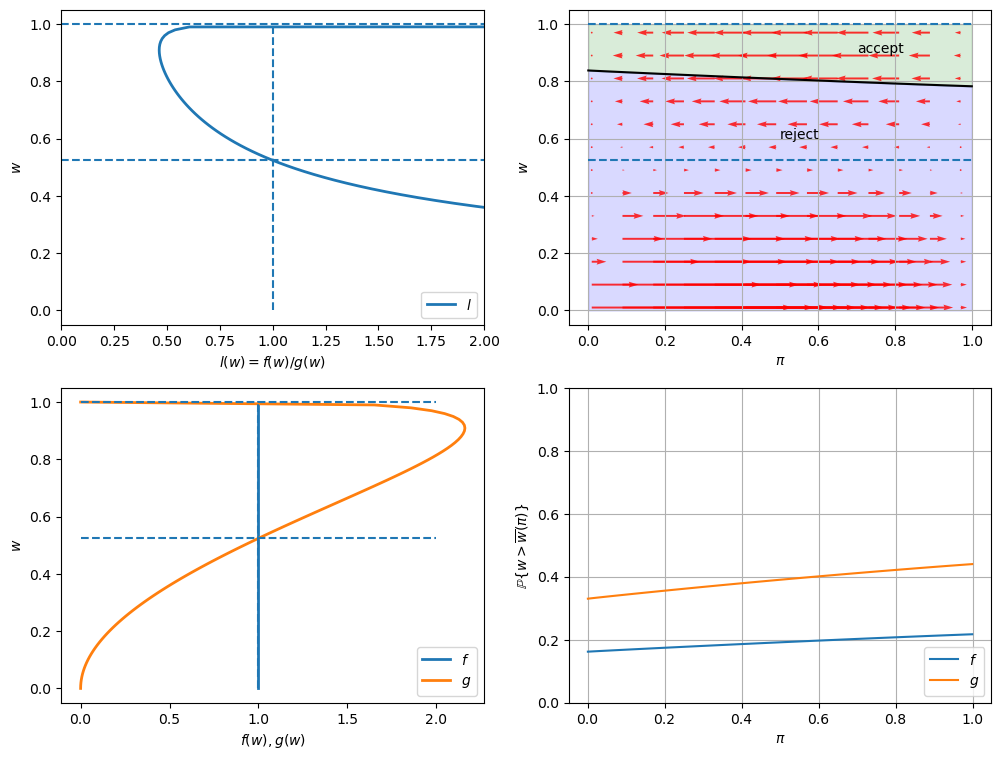

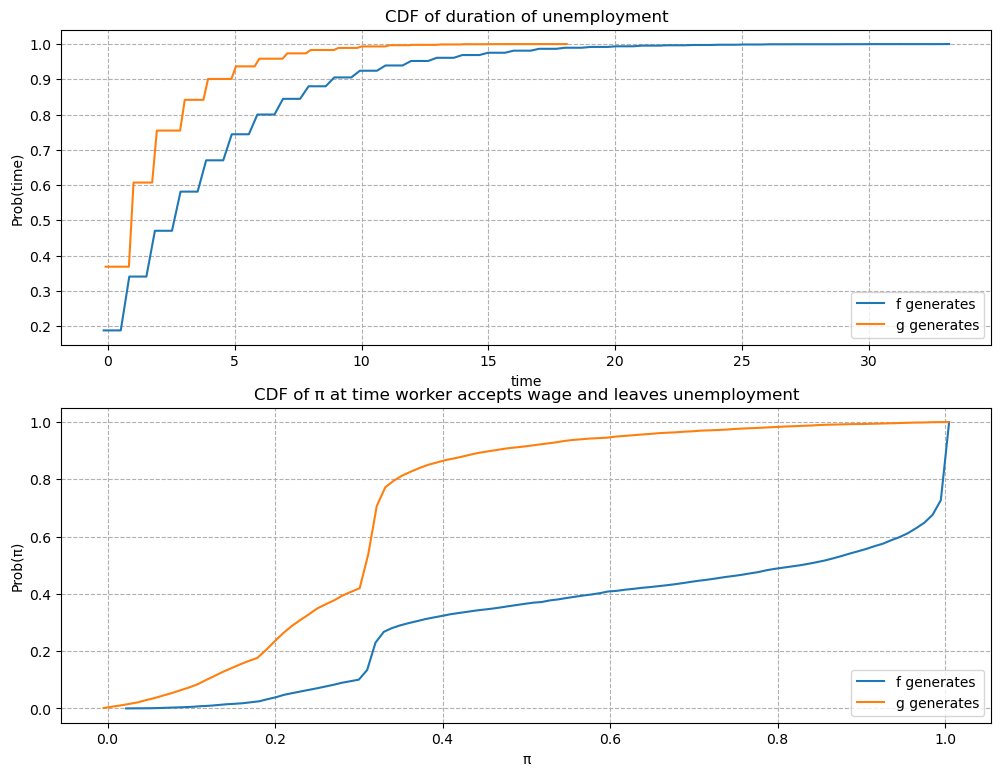

In [15]:
job_search_example()

### Example 2

$F$ ~ Beta(1, 1), $G$ ~ Beta(1.2, 1.2), $c$=0.3.

Now $G$ has the same mean as $F$ with a smaller variance.

Since the unemployment compensation $c$ serves as a lower bound
for bad wage offers, $G$ is now an “inferior” distribution to
$F$.

Consequently, we observe that the optimal policy
$\overline{w}(\pi)$ is increasing in $\pi$.

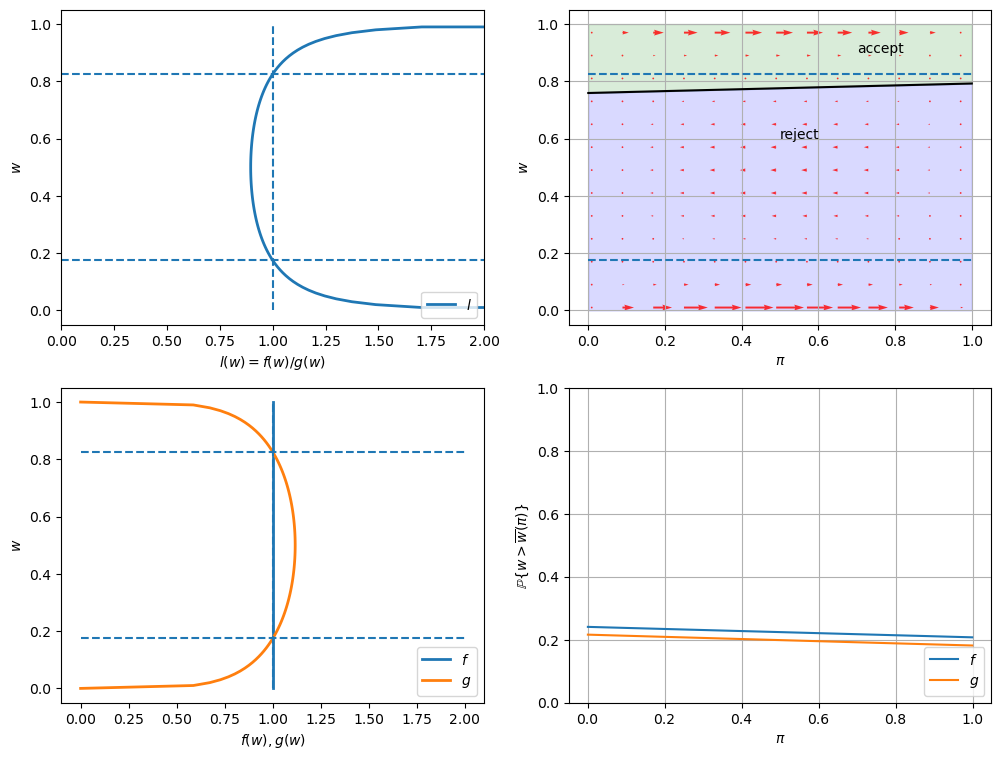

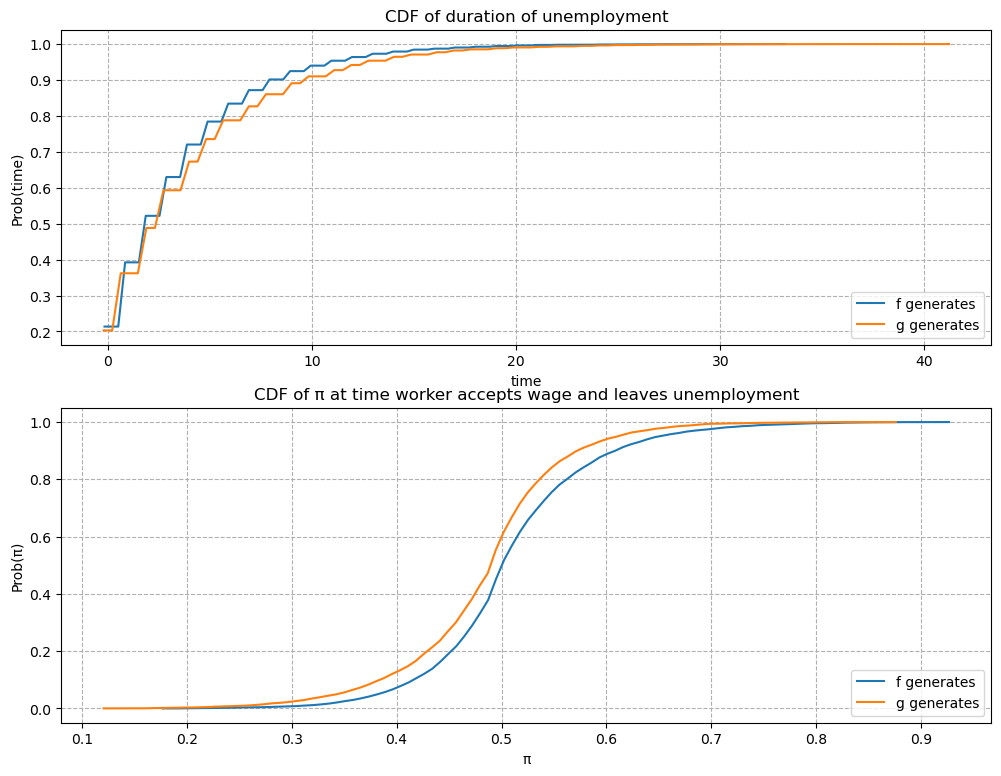

In [16]:
job_search_example(1, 1, 1.2, 1.2, 0.3)

### Example 3

$F$ ~ Beta(1, 1), $G$ ~ Beta(2, 2), $c$=0.3.

If the variance of $G$ is smaller, we observe in the result that
$G$ is even more “inferior” and the slope of
$\overline{w}(\pi)$ is larger.

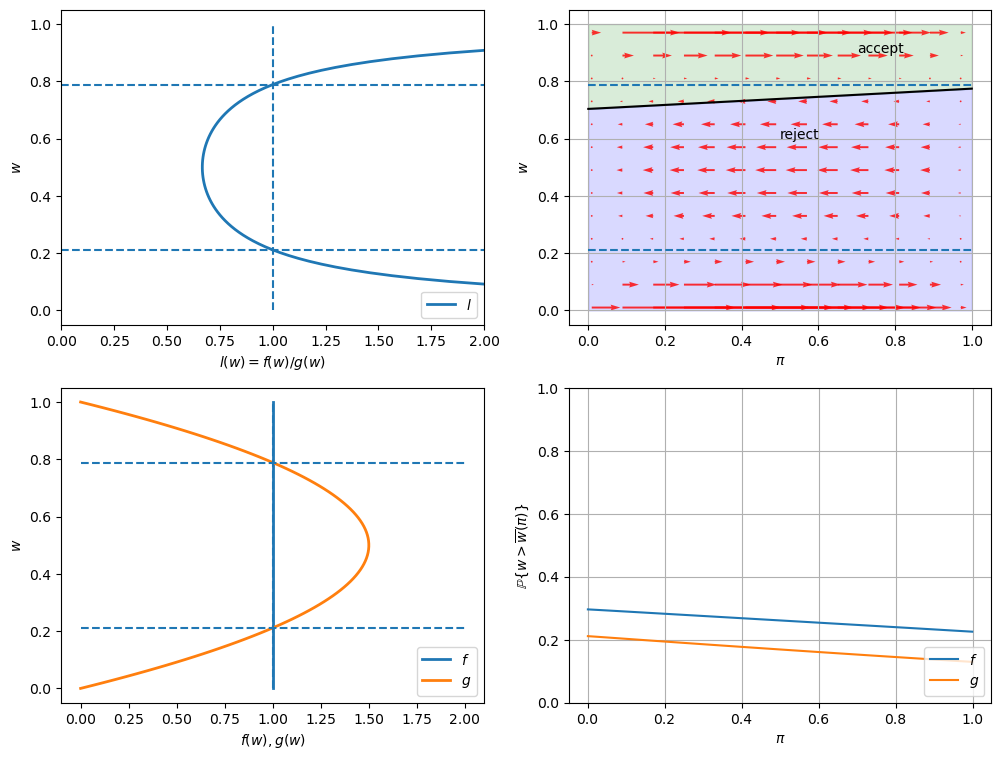

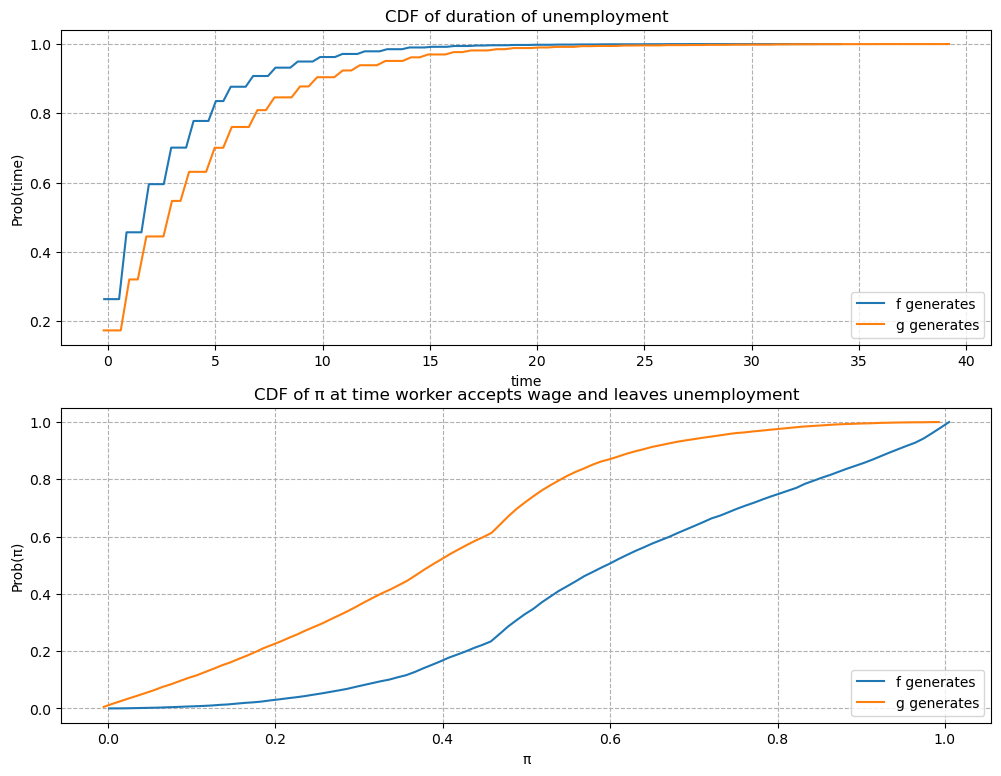

In [17]:
job_search_example(1, 1, 2, 2, 0.3)

### Example 4

$F$ ~ Beta(1, 1), $G$ ~ Beta(3, 1.2), and $c$=0.8.

In this example, we keep the parameters of beta distributions to be the
same with the baseline case but increase the unemployment compensation
$c$.

Comparing outcomes to the baseline case (example 1) in which
unemployment compensation if low ($c$=0.3), now the worker can
afford a longer  learning period.

As a result, the worker tends to accept
wage offers much later.

Furthermore, at the time of accepting employment, the belief
$\pi$ is closer to either $0$ or $1$.

That means that
the worker has a better  idea about what the true distribution is
when he eventually chooses to accept a wage offer.

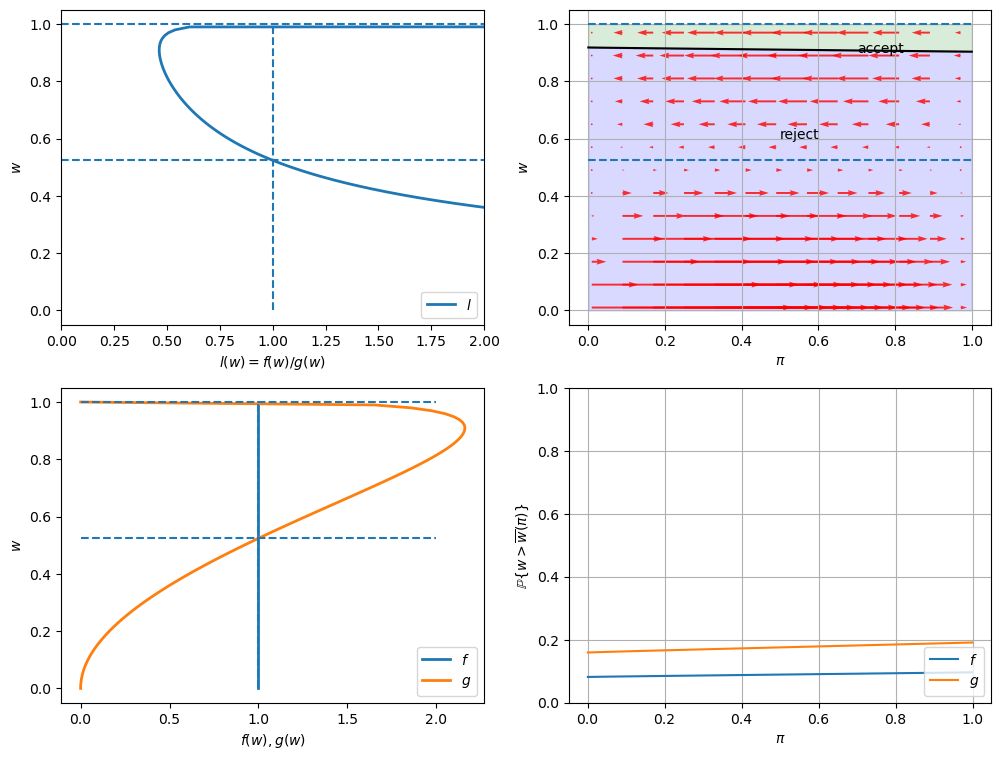

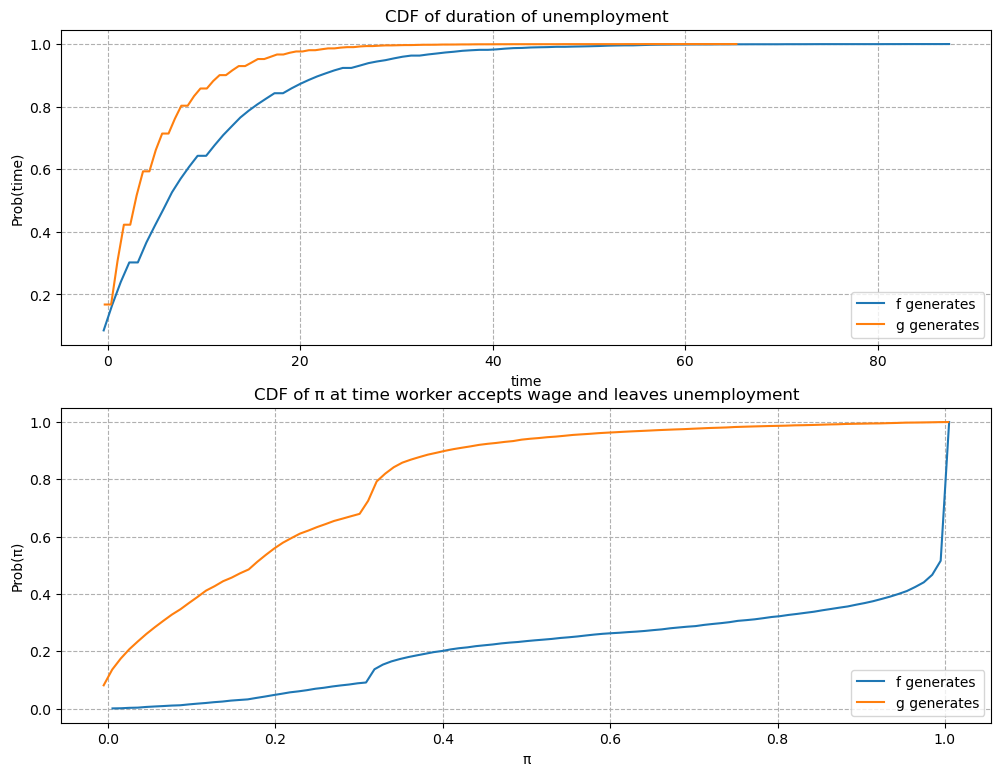

In [18]:
job_search_example(1, 1, 3, 1.2, c=0.8)

### Example 5

$F$ ~ Beta(1, 1), $G$ ~ Beta(3, 1.2), and $c$=0.1.

As expected, a smaller $c$ makes an unemployed worker  accept wage offers earlier
after having acquired less information about the wage distribution.

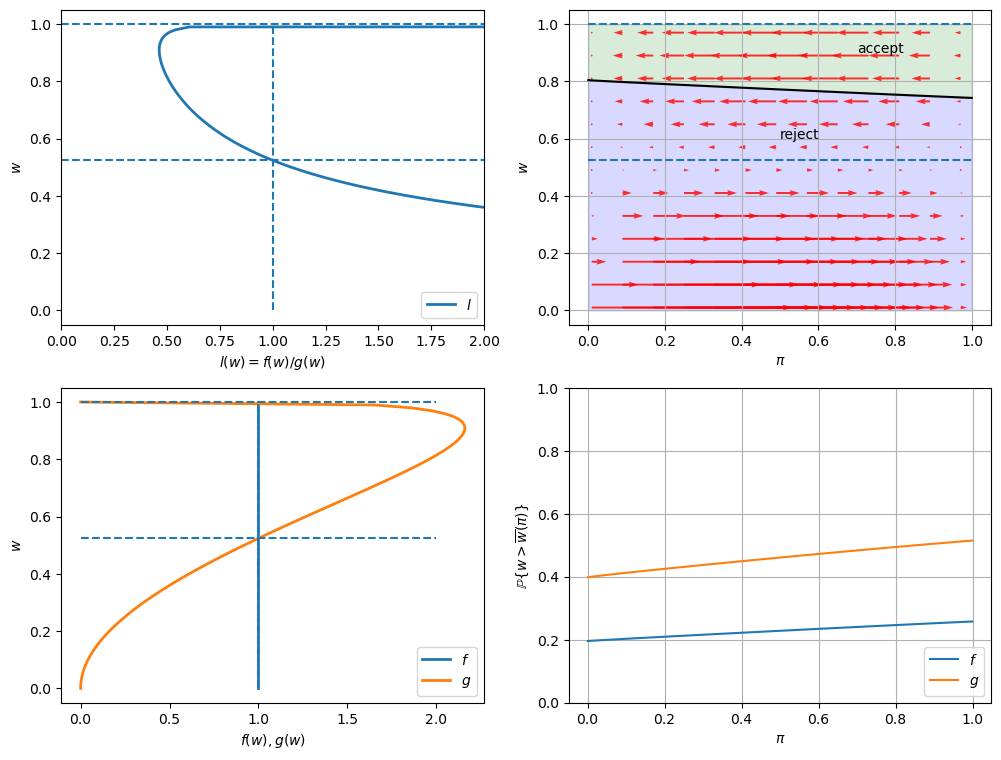

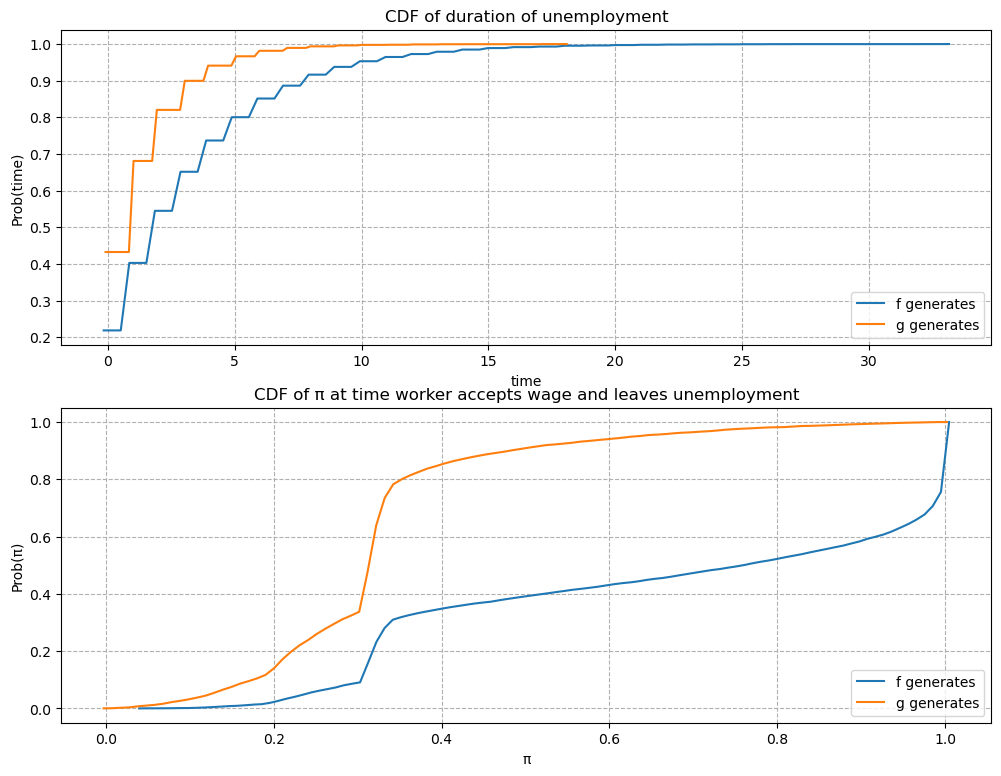

In [19]:
job_search_example(1, 1, 3, 1.2, c=0.1)